<a href="https://colab.research.google.com/github/stephenbeckr/time-series-class/blob/main/Demos/TimeSeries_GeneralizedLeastSquares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generalized least squares (GLS) for linear models with ARMA errors

We'll use the [`car`](https://cran.r-project.org/web/packages/car/index.html) R package which is a package for the textbook "An R Companion to Applied Regression" by J. Fox and S. Weisberg, Third Edition, Sage, 2019.  This will also load the `carData` package which has the dataset we want.  This demo by Will Kleiber 2018, modified by Stephen Becker 2022

Hartnagel data: CHANGING SOCIAL ROLES AND FEMALE CRIME IN CANADA: A TIME SERIES ANALYSIS, by Fox and Hartnagel (1979)

*Abstract*: Time series data on female conviction rates in Canada are examined employing multiple regression analysis to evaluate the hypotheses that the female crime rate varies inversely with the rate of involvement of females in the familial role and directly with the rate of female participation in extra familial roles. The results are generally as predicted, particularly with the female theft conviction rate as the dependent variable. Support is therefore found for the view that changes in various aspects of women's structural position in Society affect female crime rates.

See also `?carData::Hartnagel`

We'll also use [`nlme`](https://cran.r-project.org/web/packages/nlme/) "Linear and Nonlinear Mixed Effects Models" for our OLS and GLS fitting; this is a fancier version of the `lm` model for OLS for linear models.

We do this because GLS is a bit complicated. If we knew the covariance matrix, then it is simple, but we don't know that because it depends on residuals (which we get after the GLS fit), so it's a chicken-and-the-egg problem. A standard approach here is to use alternating methods, but even better is to do a combined MLE approach, which is a bit complicated, and that's what the `nlme` package can do for us.

In [ ]:
# install.packages("car")
# and dependencies:
#   ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’
# library(car)

# Actually, installing the package is slow. Let's just load the one we need
install.packages("carData")
library(carData)

install.packages("nlme")
library(nlme)

#### Look at the data, fit OLS model

In [12]:
Hartnagel[1:5,]

,year,tfr,partic,degrees,fconvict,ftheft,mconvict,mtheft
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1931,3200,234,12.4,77.1,NA,778.7,NA
2,1932,3084,234,12.9,92.9,NA,745.7,NA
3,1933,2864,235,13.9,98.3,NA,768.3,NA
4,1934,2803,237,13.6,88.1,NA,733.6,NA
5,1935,2755,238,13.2,79.4,20.4,765.7,247.1



Call:
lm(formula = fconvict ~ tfr + partic + degrees + mconvict, data = Hartnagel)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.964  -9.204  -3.566   6.149  48.385 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 127.639997  59.957044   2.129   0.0408 *  
tfr          -0.046567   0.008033  -5.797 1.75e-06 ***
partic        0.253416   0.115132   2.201   0.0348 *  
degrees      -0.212049   0.211454  -1.003   0.3232    
mconvict      0.059105   0.045145   1.309   0.1995    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.19 on 33 degrees of freedom
Multiple R-squared:  0.6948,	Adjusted R-squared:  0.6578 
F-statistic: 18.78 on 4 and 33 DF,  p-value: 3.905e-08


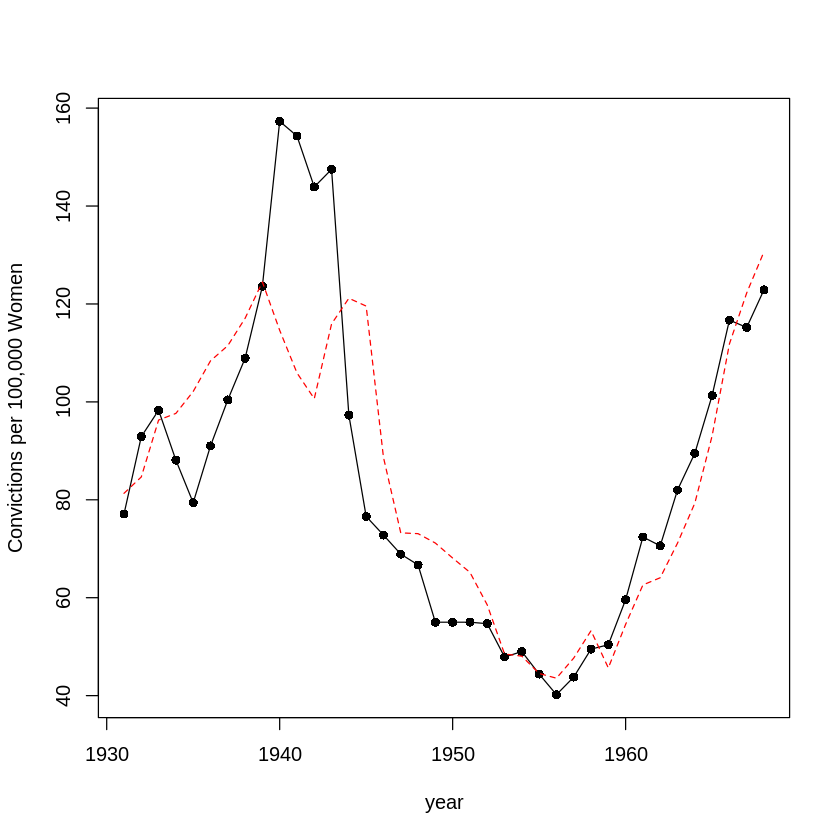

In [9]:
plot(fconvict~year, type="o", pch=16, data=Hartnagel,
  ylab="Convictions per 100,000 Women")
mod.ols <- lm(fconvict ~ tfr + partic + degrees + mconvict, data=Hartnagel)
summary(mod.ols)

lines( Hartnagel$year, predict(mod.ols),col="red",lty=2 )

and look at residuals

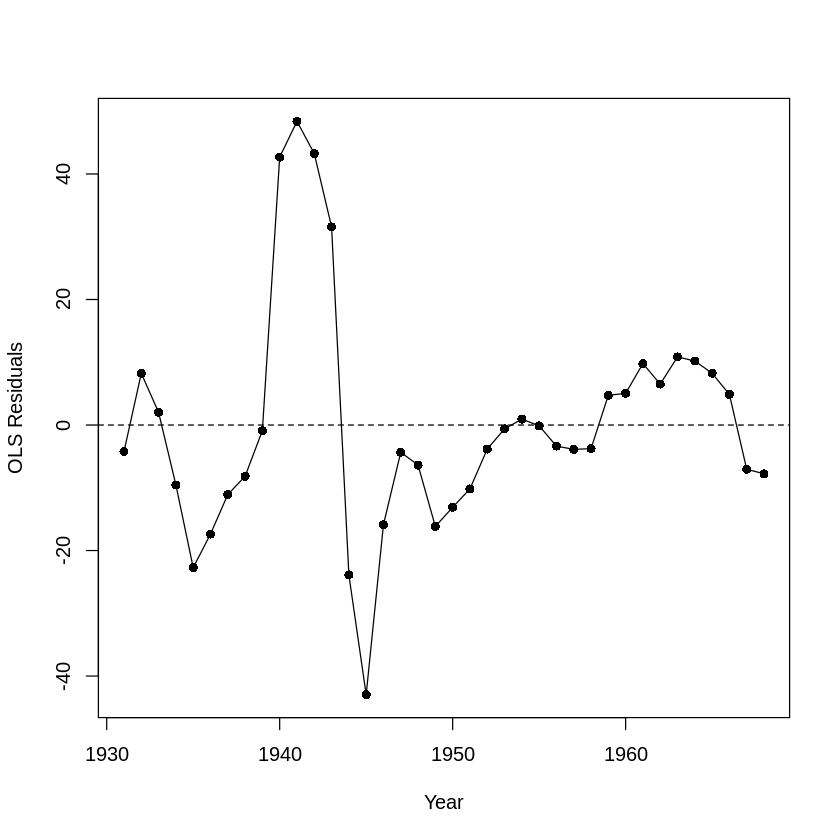

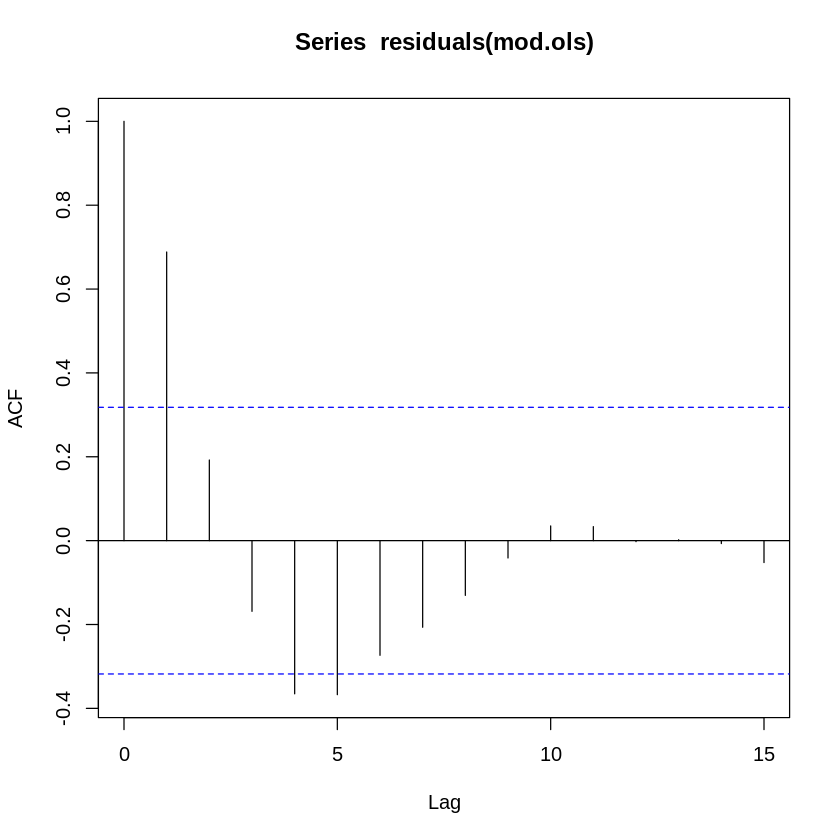

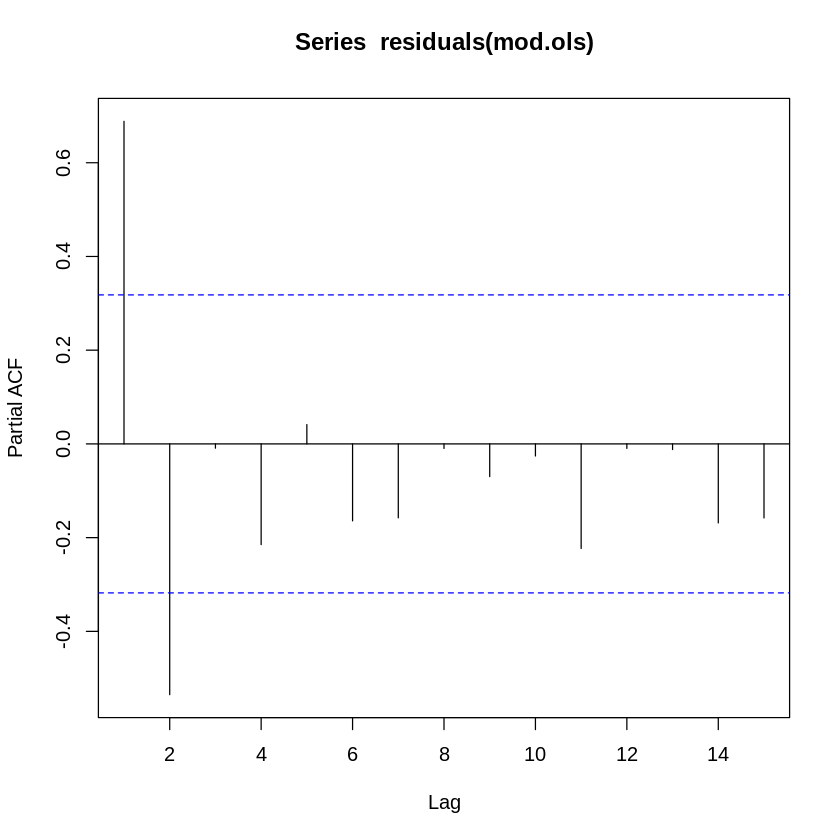

In [13]:
plot(Hartnagel$year, residuals(mod.ols), type="o", pch=16,
  xlab="Year", ylab="OLS Residuals")
abline(h=0, lty=2)
acf(residuals(mod.ols))
acf(residuals(mod.ols), type="partial")

doesn't look consistent with white noise (can also try `itsmr::test` for white noise tests)

#### Let's try GLS now

In [14]:
mod.gls <- gls(fconvict ~ tfr + partic + degrees + mconvict, data=Hartnagel,
  correlation=corARMA(p=2), method="ML")
summary(mod.gls)

Generalized least squares fit by maximum likelihood
  Model: fconvict ~ tfr + partic + degrees + mconvict 
  Data: Hartnagel 
       AIC      BIC    logLik
  305.4145 318.5152 -144.7073

Correlation Structure: ARMA(2,0)
 Formula: ~1 
 Parameter estimate(s):
      Phi1       Phi2 
 1.0683473 -0.5507269 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 83.34028  59.47084  1.401364  0.1704
tfr         -0.03999   0.00928 -4.308632  0.0001
partic       0.28761   0.11201  2.567653  0.0150
degrees     -0.20984   0.20658 -1.015757  0.3171
mconvict     0.07569   0.03501  2.161899  0.0380

 Correlation: 
         (Intr) tfr    partic degres
tfr      -0.773                     
partic   -0.570  0.176              
degrees   0.093  0.033 -0.476       
mconvict -0.689  0.365  0.047  0.082

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.4991516 -0.3716988 -0.1494540  0.3372409  2.9094711 

Residual standard error: 17.70228 
Degrees of fr

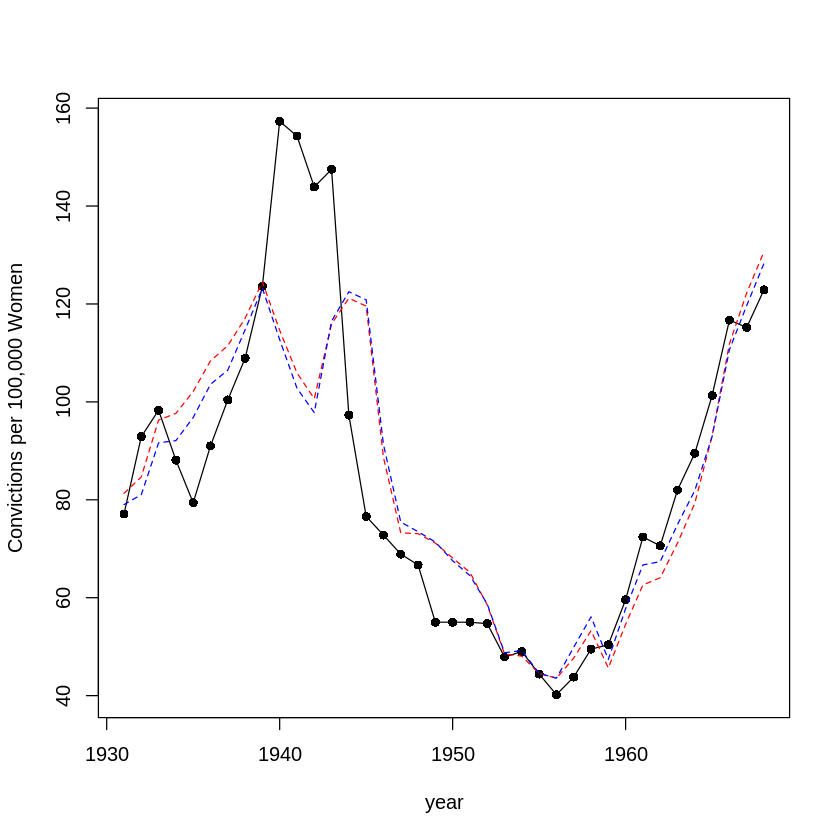

In [15]:
plot(fconvict~year, type="o", pch=16, data=Hartnagel,
  ylab="Convictions per 100,000 Women")

lines( Hartnagel$year, predict(mod.ols),col="red",lty=2 )
lines( Hartnagel$year, predict(mod.gls),col="blue",lty=2 )

Compare OLS and GLS

In [18]:
# Coefficients beta.hat
beta.hat <- cbind(mod.ols$coef,mod.gls$coef)
colnames( beta.hat ) <- c("OLS","GLS")
beta.hat 

# SE(beta.hat)
SE <- cbind(summary(mod.ols)$coef[,2],sqrt(diag(mod.gls$varBeta)))
colnames( SE ) <- c("OLS","GLS")
SE

,OLS,GLS
(Intercept),127.63999736,83.3402784
tfr,-0.04656651,-0.0399870
partic,0.25341619,0.2876118
degrees,-0.21204914,-0.2098362
mconvict,0.05910466,0.0756860


,OLS,GLS
(Intercept),59.957044218,59.470835290
tfr,0.008032987,0.009280671
partic,0.115131823,0.112013488
degrees,0.211453792,0.206580991
mconvict,0.045145314,0.035009033


Compare likelihood values (we want to minimize negative log likelihood, so want this to be small)

In [20]:
-stats::logLik(mod.ols)
-stats::logLik(mod.gls)

'log Lik.' 163.5006 (df=6)

'log Lik.' 144.7073 (df=8)

Compare AIC and BIC (also want this small)

In [21]:
cbind(AIC(mod.ols),AIC(mod.gls))
cbind(BIC(mod.ols),BIC(mod.gls))

339.0011,305.4145


348.8266,318.5152


For pure likelihood, and also both AIC and BIC, the GLS model comes out better than OLS

#### and plot GLS residuals

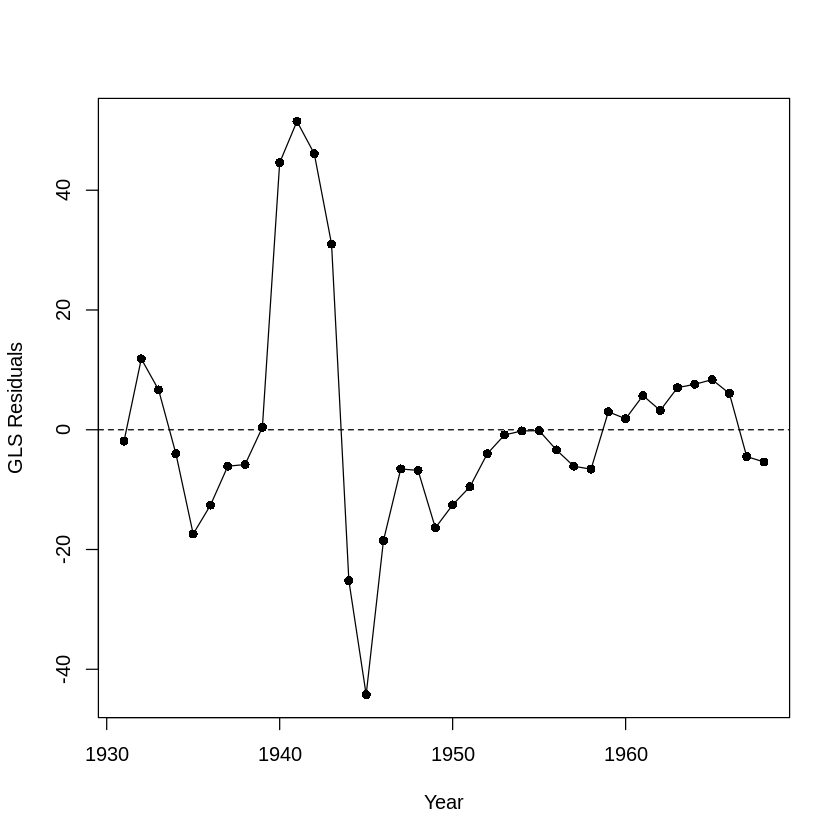

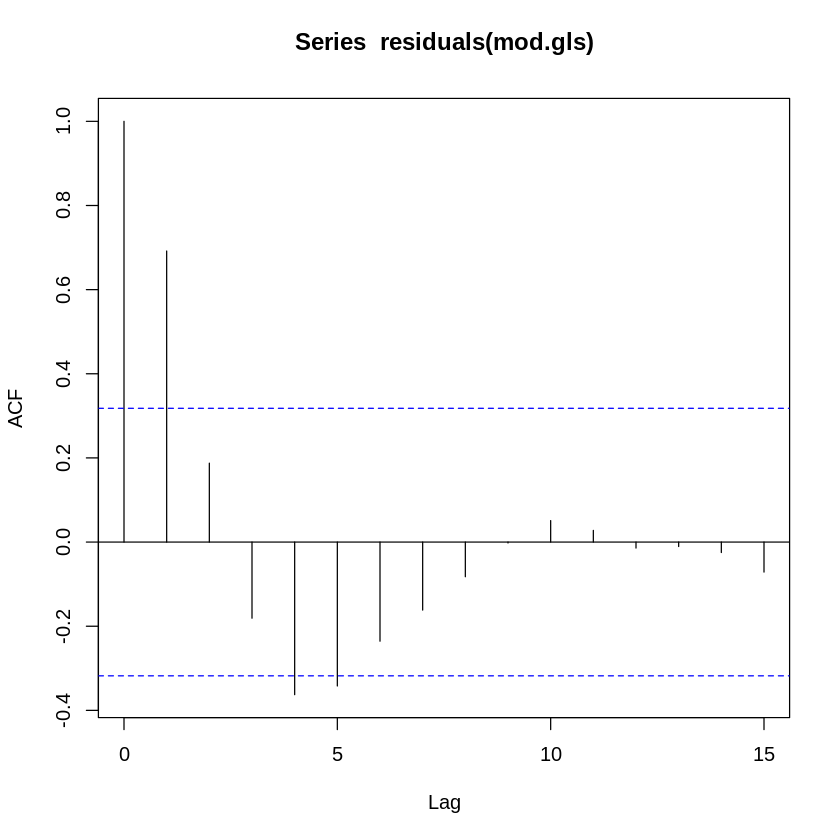

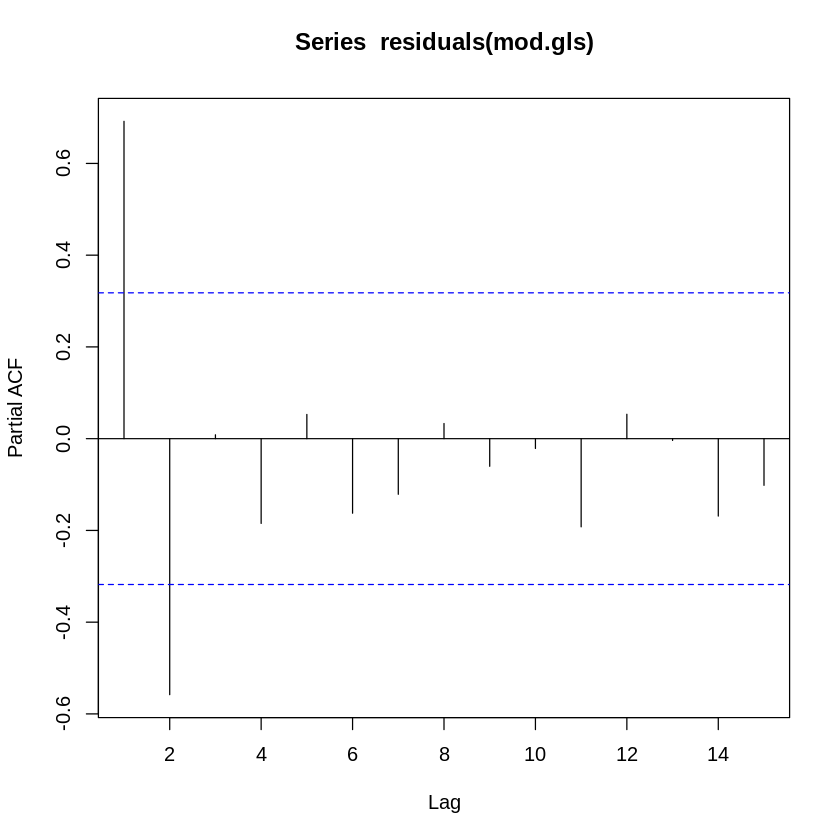

In [22]:
plot(Hartnagel$year, residuals(mod.gls), type="o", pch=16,
  xlab="Year", ylab="GLS Residuals")
abline(h=0, lty=2)
acf(residuals(mod.gls))
acf(residuals(mod.gls), type="partial")

Residuals are still not white noise... and that's OK. Because now we can try to model the residuals with an ARMA process and use that for prediction.  Remember, we were just trying to do a regression (to remove trends and explanatory variables)